<a href="https://colab.research.google.com/github/carlos20160984/ET5003_SEM1_2021-2/blob/main/ET5003_Etivity2_Draft_Carlos_Santiago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [ ]:
#@title Current Date
Today = '2021-08-26' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20160984" #@param {type:"string"}
Student_full_name = "Carlos Santiago" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# To find Feature Importnces
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [4]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The challenge is to predict the final price of each house.

In [6]:
# Import the data
Path = '/content/drive/MyDrive/etivity-2/'

# House prices Data
train_data = Path + 'house_train.csv'
test_data = Path + 'house_test.csv'
true_data = Path + 'true_price.csv'

# train data
train = pd.read_csv(train_data)

# test data
test = pd.read_csv(test_data)
true_data=pd.read_csv(true_data )
test.insert(1, "price", true_data["Expected"])

## Exploratory Data Analysis (EDA)

In [7]:
# View the first 5 rows of training set
train.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [8]:
# Describe the training set
train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


In [9]:
# Describe the testing set
test.describe()

,ad_id,price,bathrooms,beds,latitude,longitude,no_of_units,surface
count,5.000000e+02,5.000000e+02,500.000000,500.000000,500.000000,500.000000,0.0,500.000000
mean,1.231695e+07,5.810356e+05,1.994000,2.930000,53.356034,-6.247842,NaN,156.007671
std,1.485832e+05,6.009194e+05,1.106532,1.191612,0.081905,0.088552,NaN,344.497362
min,1.130615e+07,8.500000e+04,0.000000,0.000000,53.221348,-6.496987,NaN,33.500000
25%,1.228617e+07,2.950000e+05,1.000000,2.000000,53.297373,-6.296404,NaN,72.375000
50%,1.237964e+07,4.250000e+05,2.000000,3.000000,53.339547,-6.243572,NaN,98.000000
75%,1.240544e+07,5.950000e+05,3.000000,4.000000,53.381650,-6.185055,NaN,138.935000
max,1.242809e+07,5.750000e+06,8.000000,7.000000,53.619775,-6.064874,NaN,5746.536120


In [10]:
print("Property type of cases where beds = 0")
train.loc[train['beds']==0,"property_type"].value_counts(sort=False)

Property type of cases where beds = 0


terraced     3
detached     1
site        52
Name: property_type, dtype: int64

In [11]:
# Check for missing values in the training data: total missing
print("Count of missing values")
train.isna().sum()

Count of missing values


ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

In [12]:
# Check for missing values: 
print('% of missing values')
(train.isna().sum()/len(train))*100

% of missing values


ad_id                  0.000000
area                   0.000000
bathrooms              1.710262
beds                   1.710262
ber_classification    22.702884
county                 0.000000
description_block      0.000000
environment            0.000000
facility              67.639168
features               0.000000
latitude               0.000000
longitude              0.000000
no_of_units           98.021462
price                  3.018109
property_category      0.000000
property_type          1.710262
surface               18.477532
dtype: float64

Pairplots of numerical features


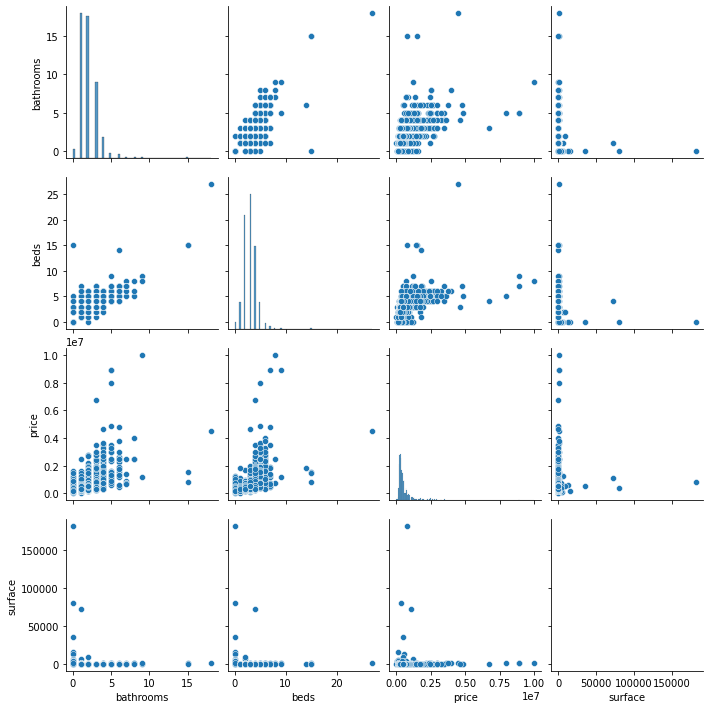

In [13]:
# Pairplot to see the relationship between numerical features. The method dropna() drops all rows with missing values 
# No of units and facility are removed due to high number of NULL values
print('Pairplots of numerical features')
sns.pairplot(data=train[['area','bathrooms','beds','price','surface']].dropna())
plt.show()

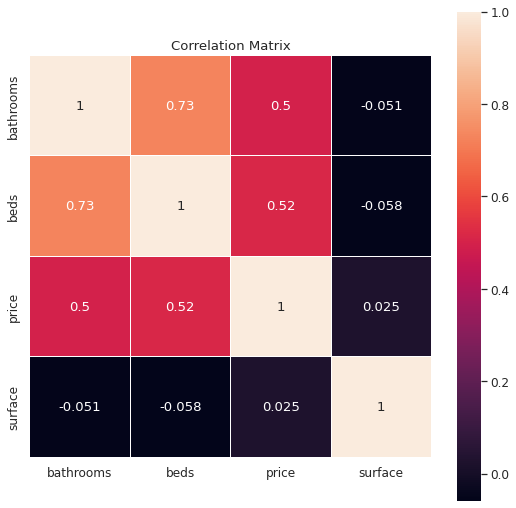

In [14]:
# Check relationships between numerical variables

train[['area','bathrooms','beds','price','surface']].dropna()

sns.set(font_scale=1.10)
plt.figure(figsize=(9, 9))
plt.title('Correlation Matrix')
sns.heatmap(train[['area','bathrooms','beds','price','surface']].corr(),linewidths=0.01,
            square=True,annot=True)


Text(0.5, 1.0, 'Count of BER for 2nd hand properties')

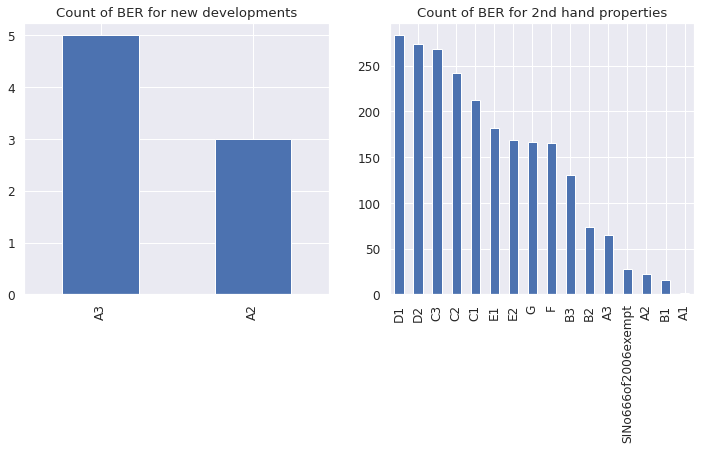

In [15]:
# Plot couting of BER rating by property category 

ber_new=train[train['property_category']=='new_development_parent']
ber_used=train[train['property_category']=='sale']


plt.subplots(2,2,figsize=(12,5))
plt.subplot(1, 2, 1) 
ber_new['ber_classification'].value_counts().plot(kind='bar')
plt.title('Count of BER for new developments')
plt.subplot(1, 2, 2) 
ber_used['ber_classification'].value_counts().plot(kind='bar')
plt.title('Count of BER for 2nd hand properties')


Text(0.5, 1.0, 'Number of properties by type')

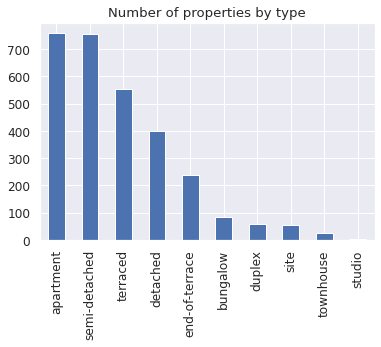

In [16]:
# Plot count and frequency of type
train['property_type'].value_counts(sort=True).plot(kind='bar')
plt.title('Number of properties by type')



Boxplot of each property type


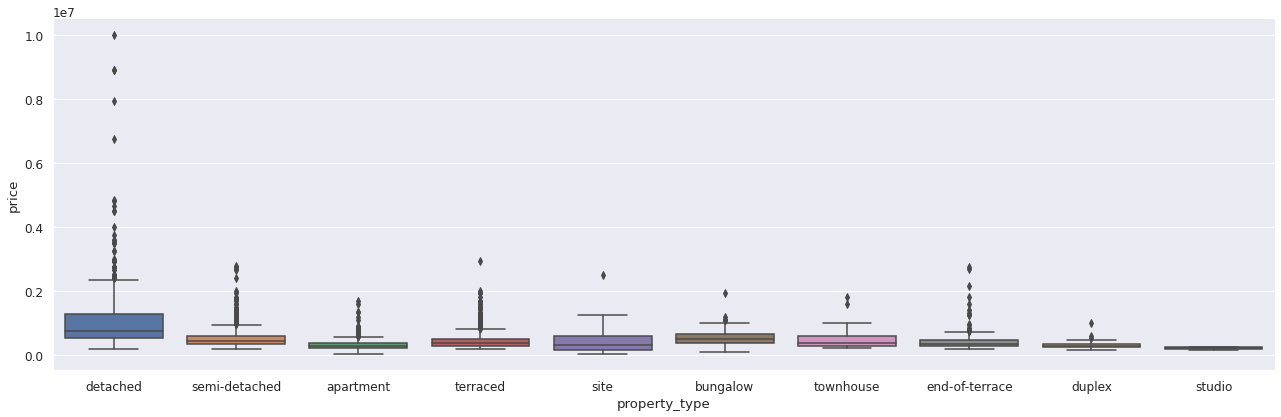

In [17]:
"""Generate two plots with the combined distribution of attributes and draw conclusions from them"""

# Boxplot of each property type
print("Boxplot of each property type")
sns.catplot(data=train, x='property_type', y='price', kind='box', height=6, aspect=15/5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


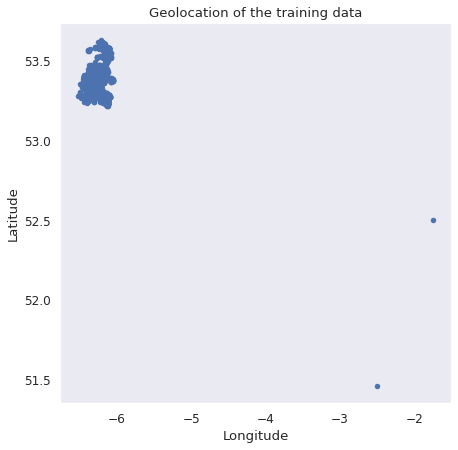

In [37]:
# Geolocation of the training data
train.plot.scatter(x = 'longitude', y = 'latitude', figsize = (7,7))
plt.title("Geolocation of the training data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

**Summary EDA: train data**

* 1.7% of new developments are missing *price, bathroom, beds, BER, facilities,features and property type* data. These are all entries of new developments where up to 36 properties were recorded together.  
* 56 properties have beds: 52 sites, 3 detached and 1 terraced.
* A further 38 instances of second hand properties are missing price
* 98% of the entries are missing *no of units* and 68% are missing *facility* input.
* BER rating is missing for 22% of the records. A breakdown of BER by *property category* - *new development* or *sale* (2nd hand) - shows that all new developments are either rating A2 or A3. On the other hand, very few 2nd hand properties are rating A. 
* 18% of training instances are missing surface
* Beds and bathrooms have a strong relationship of 0.73 meaning that number of bathrooms increase with the number of beds 
* There is a positive relationship of 0.51 between number of beds and price
* Detached houses account for most outliers.
* Description block is informative. However, most inputs are unique. It would be useful for creating new features from key works. 
* Features input are useful for creating new features such as type of heating and alarm system with data engineering tools.
* All areas are located in Co. Dublin
* A few istances have longitude and/or latitude inconsistent with county Dublin
* 551 entries (18%) are blank for surface. 

# Data preparation

**Drop meaningless Features:**<br>
* Drop *ad_ID* as it is just an unique id
* Drop county as all instances are in Dublin
* Drop the variable *environment* as it is not related to the property features
* Drop the variable *feature and description block* because their inputs are very diverse. It would be useful only if we created new features from key words<p>

**Convert Categorical Features:**<p>
* Apply one hot encoding to *area, property_category and, property_type* 
* Convert *BER classification* into ordinal features


**Missing data:**<p>
* **Missing most features**: remove the 51 recods missing price, bathroom, beds, BER, facilities,features and property type data. These data refer to developments that recorded multiple units together.
* **Missing bed**: delete instances where beds = 0 and property type is not site.
* **no of units**: drop the feature no of units as 98% of the instances are NAs.
* **facility**: drop facility as 68% of the instances are NAs.
* **Missing BER**: input the average of BER where missing taking the property category into account as all new developments are rating A.
* **Surface:** surface has litle to no correlation  with other variables. Hence, will input the mean into missing entries.

**Outliers/Inconsistent data**<p>
* Remove longitude >-6 as it is not consistent with county Dublin

99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean. We can remove extreme values by deleting the rows where values are above/below the threshold of 3 standard deviations. 

* Remove rows where prices are 3+ standard deviations above/below the mean.
* Remove rows where surfaces are 3+ standard deviations above/below the mean. 


**Drop meaningless Features:**

In [38]:
# Drop columns
train.drop(['ad_id','county','environment','features','facility','no_of_units','description_block'], axis=1, inplace=True)
test.drop(['ad_id','county','environment','features','facility','no_of_units','description_block'], axis=1, inplace=True)


**Input/drop missing data**

In [39]:
# Remove any row missing price entry. The same rows are also missing  bathroom, beds, BER, facilities,features and property type data.
train.dropna(subset=['price'], axis=0, inplace=True) # drop rows missing price

In [40]:
# Remove rows where beds = 0 and property type is not site
train = train.drop(train[(train['beds']==0 ) & (train['property_type']!='site')].index) # Remove outliers based on price
test = test.drop(test[(test['beds']==0 ) & (test['property_type']!='site')].index) # Remove outliers based on price
#print("Type of properties with no beds:")
#train.loc[train['beds']==0,"property_type"].value_counts(sort=False)



In [41]:
# Input mean for any missing surface entries
train['surface'].fillna(train['surface'].mean(), inplace=True)
test['surface'].fillna(test['surface'].mean(), inplace=True)

In [42]:
#Convert BER classification into ordinal features
# Map BER categories 
BERMap = {
    "A1": 1,
    "A2": 2,
    "A3": 3,
    "B1": 4,
    "B2": 5,
    "B3": 6,
    "C1": 7,
    "C2": 8,
    "C3": 9,
    "D1": 10,
    "D2": 11,
    "E1": 12,
    "E2": 13,
    "F": 14,
    "G": 15,
    "SINo666of2006exempt" : 16
}
train['ber_classification'] = train['ber_classification'].replace(BERMap)
test['ber_classification'] = test['ber_classification'].replace(BERMap)

In [43]:
# Replace 'N/A' values in ber_classification with mean of the same property category

ber_new=train[train['property_category']=='new_development_parent']
ber_used=train[train['property_category']=='sale']

ber_new_avg = round(ber_new['ber_classification'].mean(),0) # mean of ber classification rounded to the nearest whole number. 
ber_used_avg = round(ber_used['ber_classification'].mean(),0) # mean of ber classification rounded to the nearest whole number. 

train['ber_classification'].fillna(ber_used_avg, inplace=True) # Only 2nd hand properties are missing BER. Therefore, we input the average for 2nd hand ones
test['ber_classification'].fillna(ber_new_avg, inplace=True) # Only 2nd hand properties are missing BER. Therefore, we input the average for 2nd hand ones

print("BER classification replacing missing values for 2nd hand properties: ",ber_used_avg)

BER classification replacing missing values for 2nd hand properties:  10.0


**Check train and testing sets for missing values**

In [44]:
# Check for missing values in the training data: total missing
print("Count of missing values")
train.isna().sum()

Count of missing values


area                  0
bathrooms             0
beds                  0
ber_classification    0
latitude              0
longitude             0
price                 0
property_category     0
property_type         0
surface               0
dtype: int64

In [45]:
test.isna().sum()

price                 0
area                  0
bathrooms             0
beds                  0
ber_classification    0
latitude              0
longitude             0
property_category     0
property_type         0
surface               0
dtype: int64

**Convert Categorical Features**

In [46]:
# Apply one hot encoding to Area
train = pd.get_dummies(train, columns=['area'], 
                        dummy_na=False, 
                        drop_first=True)

test = pd.get_dummies(test, columns=['area'], 
                        dummy_na=False, 
                        drop_first=True)


In [47]:
# Apply one hot encoding to property_category
train = pd.get_dummies(train, columns=['property_category'], 
                        dummy_na=False, 
                        drop_first=False)

test = pd.get_dummies(test, columns=['property_category'], 
                        dummy_na=False, 
                        drop_first=False)


In [48]:
# Apply one hot encoding to property_type
train = pd.get_dummies(train, columns=['property_type'], 
                        dummy_na=False, 
                        drop_first=True)

test = pd.get_dummies(test, columns=['property_type'], 
                        dummy_na=False, 
                        drop_first=True)

train.tail()

,bathrooms,beds,ber_classification,latitude,longitude,price,surface,area_Ard Na Greine,area_Artane,area_Ashtown,area_Balbriggan,area_Baldoyle,area_Balgriffin,area_Ballinteer,area_Ballsbridge,area_Ballybough,area_Ballyboughal,area_Ballybrack,area_Ballycullen,area_Ballyfermot,area_Ballymount,area_Ballymun,area_Balrothery,area_Beaumont,area_Blackrock,area_Blanchardstown,area_Bluebell,area_Booterstown,area_Brittas,area_Cabinteely,area_Cabra,area_Carpenterstown,area_Carrickmines,area_Castleknock,area_Chapelizod,area_Cherry Orchard,area_Christchurch,area_Churchtown,area_Citywest,area_Clarehall,...,area_Rathmichael,area_Rathmines,area_Rialto,area_Ringsend,area_Rush,area_Saggart,area_Sallynoggin,area_Sandycove,area_Sandyford,area_Sandymount,area_Santry,area_Shankill,area_Skerries,area_Smithfield,area_South Circular Road,area_Stepaside,area_Stoneybatter,area_Sutton,area_Swords,area_Tallaght,area_Temple Bar,area_Templeogue,area_Terenure,area_The Coombe,area_The Ward,area_Tyrrelstown,area_Walkinstown,area_Whitehall,area_Windy Arbour,property_category_new_development_parent,property_category_sale,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
2977,2.0,2.0,9.0,53.338738,-6.237199,415000.0,56.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2978,1.0,3.0,5.0,53.335793,-6.294268,485000.0,101.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2979,1.0,2.0,9.0,53.346098,-6.276856,299000.0,55.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2980,2.0,3.0,9.0,53.273518,-6.178500,495000.0,97.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2981,2.0,3.0,11.0,53.310073,-6.325158,525000.0,129.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


**Remove outliers**

In [49]:
def remove_outliers(dframe, feature, no_std=3):
    '''Function to Detect / Remove Outliers'''
  
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(dframe[feature])
    random_data_mean = np.mean(dframe[feature])
    anomaly_cut_off = random_data_std * no_std
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    
    dframe = dframe.drop(dframe[(dframe[feature] < lower_limit) | (dframe[feature] > upper_limit)].index)

    return dframe 

In [50]:
# Remove extreme values for price and surface. We are using 3 stantard deviations as a cut off
train = remove_outliers(train, 'price', 3)
train = remove_outliers(train, 'surface', 3)


In [51]:
# Drop  location inconsistent with county Dublin
InconsistentLongitude = train[train['longitude'] > -6].index
train.drop(InconsistentLongitude, inplace=True)

## Training & Test Data

In [52]:
#Seperate X, y columns from training data
y = train['price']
X = train.drop('price', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

print("Shape of training set:", X_train.shape)
print("Shape of testing set",y_test.shape)

Shape of training set: (2258, 168)
Shape of testing set (565,)


## Feature Importance with Random Forest

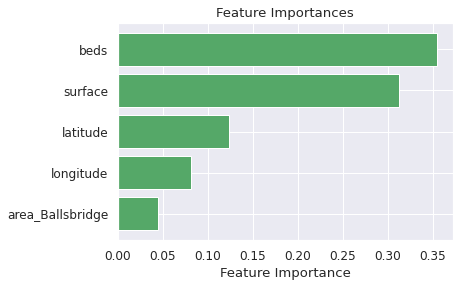

In [53]:
#Determine the most relevant features

model = RandomForestRegressor(random_state=8, max_depth=8)
model.fit(X_train, y_train)

features = train.drop('price', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[-5:]  # top 5 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

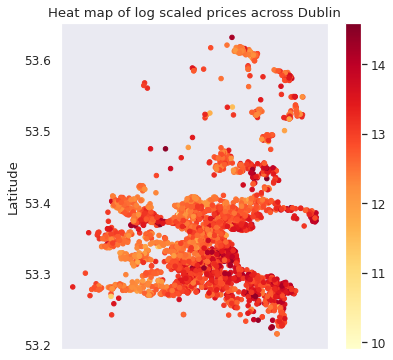

In [57]:
# Log transforming the price to remove heat map sensitivity to outliers
train.plot.scatter(x = 'longitude', y = 'latitude', c = np.log(train['price']), cmap = 'YlOrRd', figsize = (6,6))
plt.title("Heat map of log scaled prices across Dublin")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

The features *beds, surface, latutude, longitude* and *area_Ballsbrige* will be selected for the piecewise regression as they are more relevant to predict prices across Dublin.
Interesting to see that latutude and longitude combined are very powerful for detecting variations across the county. We can see on the heapmap that prices goes up toward south and east areas.

### Train dataset

# PIECEWISE REGRESSION

## Full Model

In [58]:
# Based on the above results, we select the most important features
dftrain = train
dftest=test
dfcost=test['price']
featrain = ['beds','area_Ballsbridge','latitude', 'longitude', 'surface','price']
df_subset_train = dftrain[featrain].dropna(axis=0)

featest = ['beds','area_Ballsbridge','latitude', 'longitude','surface']
df_subset_test  =  dftest[featest].dropna(axis=0)

# cost
df_subset_cost = dfcost[dfcost.index.isin(df_subset_test.index)]

print(df_subset_train.shape)
print(df_subset_test.shape)
print(df_subset_cost.shape)

(2823, 6)
(500, 5)
(500,)


In [59]:
print(dfcost)

0      875000.0
1      355000.0
2      440000.0
3      425000.0
4      265000.0
         ...   
495    345000.0
496    775000.0
497    360000.0
498    925000.0
499    325000.0
Name: price, Length: 500, dtype: float64


In [60]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = dfcost.values

In [61]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [62]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 2,893.2


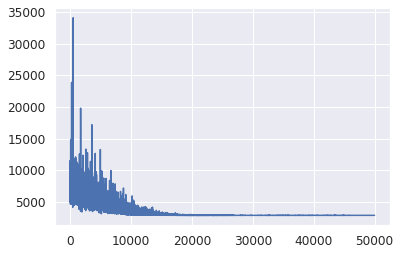

In [63]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [64]:
# samples from the posterior
posterior = approximation.sample(draws=5000)
print(posterior)

<MultiTrace: 1 chains, 5000 iterations, 4 variables>


In [65]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  205077.876061387
MAPE =  0.26730764131959595


## Clustering

### Full Model

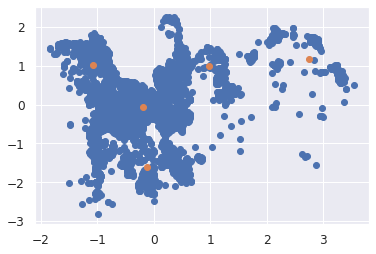

In [66]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5)

# clustering by features latitude and longitude
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)

# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])


### Clusters

In [67]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 1477, 1: 278, 2: 185, 3: 396, 4: 487}

In [68]:

# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 269, 1: 46, 2: 41, 3: 84, 4: 60}

In [69]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)


In [70]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [71]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [72]:

# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

In [73]:

# cluster 4
Xn4 = Xn_train[clusters_train==4,:]
Xtestn4 = Xn_test[clusters_test==4,:]
ylog4 = np.log(ys_train.astype('float')[clusters_train==4,:])
yscaler4 = StandardScaler().fit(ylog4)
yn4 = yscaler4.transform(ylog4)

## Piecewise Model

In [74]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,469.8


In [75]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 303.7


In [76]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 232.18


In [77]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 456.44


In [78]:
# model_4
with pm.Model() as model4:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn4.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn4[:,0])
    
with model4:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior4 = approximation.sample(5000)

Finished [100%]: Average Loss = 548.79


In [79]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

##Simulations

### Only Cluster 0

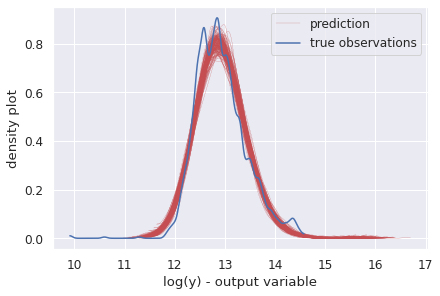

In [80]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

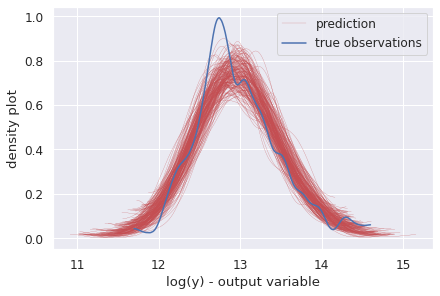

In [81]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

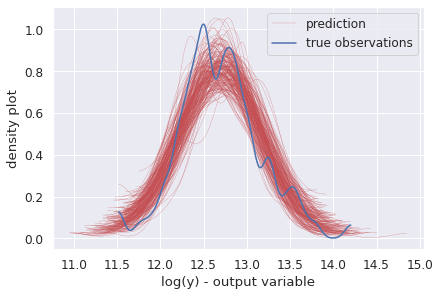

In [82]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 3

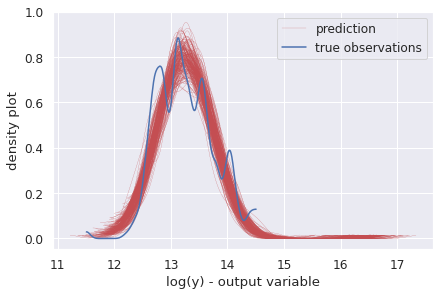

In [83]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 4

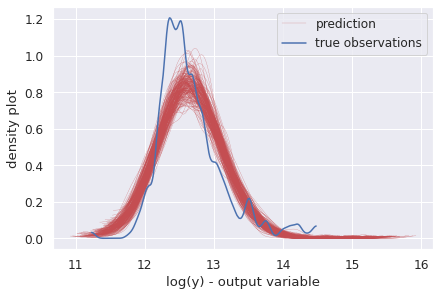

In [84]:
#Simulation
Ypred4 = yscaler4.inverse_transform(ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xn4,  nsamples=200))
for i in range(Ypred4.shape[0]):
    az.plot_dist( Ypred4[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred4[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog4,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

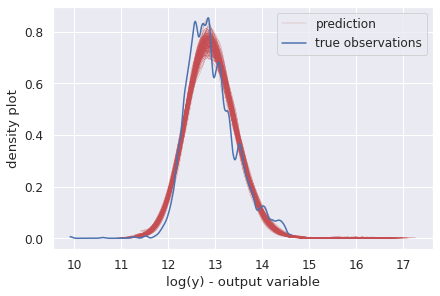

In [85]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)
Ypred4 = ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xn4,  nsamples=200)



# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4),
                 ])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0, ylog1, ylog2, ylog3, ylog4])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

### PPC on the Test set



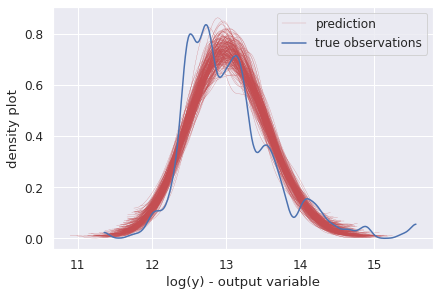

In [86]:
## Posterior predictive checks (PPCs)

Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=200)
Ypred4 = ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xtestn4, nsamples=200)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler3.inverse_transform(Ypred4)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY

WIP